<a href="https://colab.research.google.com/github/lOmarMisbahl/FaceRecognition/blob/main/CompareVsNon_FaceImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from os import listdir
from PIL import Image as PImage
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def loadImages(path):
    foldersList = listdir(path)
    loadedImages = []
    for folder in foldersList :
        imagesList = listdir(path+folder)
        for image in imagesList:
            img = PImage.open(path +folder+'/'+ image)
            loadedImages.append(img)
    return loadedImages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/ORL/"
imgs = loadImages(path)

In [ ]:
cifarpath = "/content/drive/MyDrive/CIFAR/"
cifar = loadImages(cifarpath)

In [ ]:
dataMatrix = np.arange(800*5600).reshape(800,5600)
label = []
for i in range(0,400) :
    dataMatrix[i] = np.array(imgs[i]).flatten()
    label.append(1)
for i in range(400,800) :
    dataMatrix[i] = np.array(cifar[i-400]).flatten()
    label.append(2)

In [ ]:
trainSet=np.arange(400*5600).reshape(400,5600)
testSet=np.arange(400*5600).reshape(400,5600)
trainLabel=[]
testLabel=[]
j,k=0,0
for i in range(0,800):
    if(i%2==0):
        testSet[j]=dataMatrix[i]
        testLabel.append(label[i])
        j+=1
    else:
        trainSet[k]=dataMatrix[i]
        trainLabel.append(label[i])
        k+=1

In [ ]:
trainMean=np.mean(trainSet,axis=0)
centeredTrainMatrix=trainSet-trainMean
covMatrix = (1/400)*np.dot(np.transpose(centeredTrainMatrix), centeredTrainMatrix)

In [ ]:
eigVal,eigVect=np.linalg.eigh(covMatrix)
idx = eigVal.argsort()[::-1]
sortedEigVal = np.real(eigVal[idx])
sortedEigVect = np.real(eigVect[:,idx])

In [ ]:
def computeDimensionality(eigVal,threshold):
    dataVariance=np.sum(eigVal)
    fractionOfTotalVariance,R,eigValSum=0,1,0
    while(fractionOfTotalVariance<threshold):
        eigValSum+=eigVal[R-1]
        fractionOfTotalVariance=eigValSum/dataVariance
        R+=1
    return R

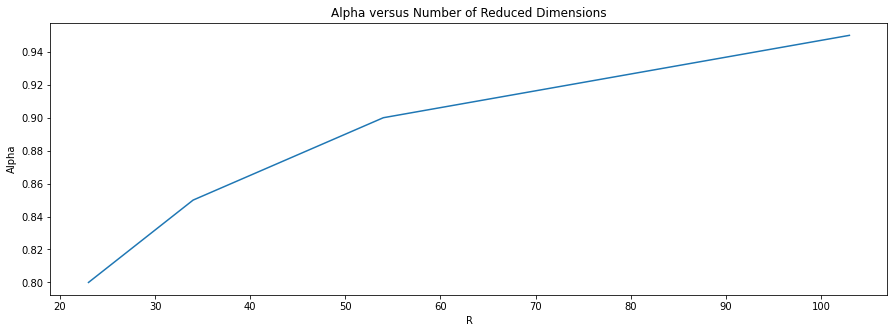

In [ ]:
Alpha1dim=computeDimensionality(sortedEigVal,0.8)
Alpha2dim=computeDimensionality(sortedEigVal,0.85)
Alpha3dim=computeDimensionality(sortedEigVal,0.9)
Alpha4dim=computeDimensionality(sortedEigVal,0.95)
plt.plot([Alpha1dim,Alpha2dim,Alpha3dim,Alpha4dim], [0.8,0.85,0.9,0.95]);
plt.title('Alpha versus Number of Reduced Dimensions');
plt.gcf().set_size_inches(15,5);
plt.xlabel('R');
plt.ylabel('Alpha');

In [ ]:
projMat1=sortedEigVect[:,0:Alpha1dim]
projMat2=sortedEigVect[:,0:Alpha2dim]
projMat3=sortedEigVect[:,0:Alpha3dim]
projMat4=sortedEigVect[:,0:Alpha4dim]

In [ ]:
reducedTrain1= np.dot(trainSet,projMat1)
reducedTrain2= np.dot(trainSet,projMat2)
reducedTrain3= np.dot(trainSet,projMat3)
reducedTrain4= np.dot(trainSet,projMat4)

In [ ]:
reducedTest1= np.dot(testSet,projMat1)
reducedTest2= np.dot(testSet,projMat2)
reducedTest3= np.dot(testSet,projMat3)
reducedTest4= np.dot(testSet,projMat4)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [ ]:
def knn(trainingSet,trainingLabel,testSet,testLabel,k):
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(trainingSet,trainingLabel)
    predict=knn.predict(testSet)
    accuracy=metrics.accuracy_score(testLabel,predict)
    return accuracy

In [ ]:
knn(reducedTrain1,trainLabel,reducedTest1,testLabel,1)

0.975

In [ ]:
knn(reducedTrain2,trainLabel,reducedTest2,testLabel,1)

0.97

In [ ]:
knn(reducedTrain3,trainLabel,reducedTest3,testLabel,1)

0.9725

In [ ]:
knn(reducedTrain4,trainLabel,reducedTest4,testLabel,1)

0.9775

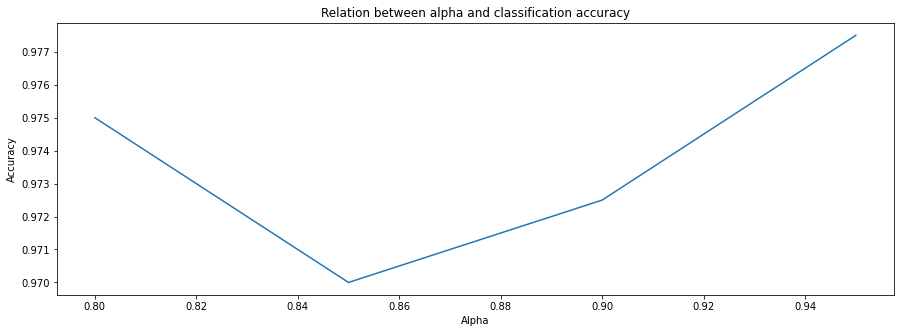

In [ ]:
plt.plot([0.8,0.85,0.9,0.95],[0.975,0.97,0.9725,0.9775]);
plt.title('Relation between alpha and classification accuracy');
plt.gcf().set_size_inches(15,5);
plt.xlabel('Alpha');
plt.ylabel('Accuracy');

In [ ]:
classesList=[]
classesList.append(trainSet[0:200,:])
classesList.append(trainSet[200:400,:])

In [ ]:
classesMeans=[]
classesMeans.append(np.mean(trainSet[0:200,:],axis=0))
classesMeans.append(np.mean(trainSet[200:400,:],axis=0))

In [ ]:
withinClassScatterMatrix = np.zeros((5600,5600))
for i in range(0,2):                                        
    centeredMatrix = (classesList[i]-classesMeans[i])
    withinClassScatterMatrix += np.dot(np.transpose(centeredMatrix),centeredMatrix)

In [ ]:
betweenClassScatterMatrix = np.zeros((5600,5600))
betweenClassScatterMatrix=np.outer(classesMeans[0]-classesMeans[1],np.transpose(classesMeans[0]-classesMeans[1]))

In [ ]:
withinClassScatterMatrixInv = np.linalg.pinv(withinClassScatterMatrix)

In [ ]:
sinverse_b = np.dot(withinClassScatterMatrixInv , betweenClassScatterMatrix)

In [ ]:
eigValLDA,eigVectLDA = np.linalg.eig(sinverse_b)

In [ ]:
idx = eigValLDA.argsort()[::-1]
sortedEigVectLDA = np.real(eigVectLDA[:,idx])

In [ ]:
reducedTrainLDA = np.dot(trainSet,sortedEigVectLDA)
reducedTestLDA = np.dot(testSet,sortedEigVectLDA)

In [ ]:
knn(reducedTrainLDA,trainLabel,reducedTestLDA,testLabel,1)

0.92

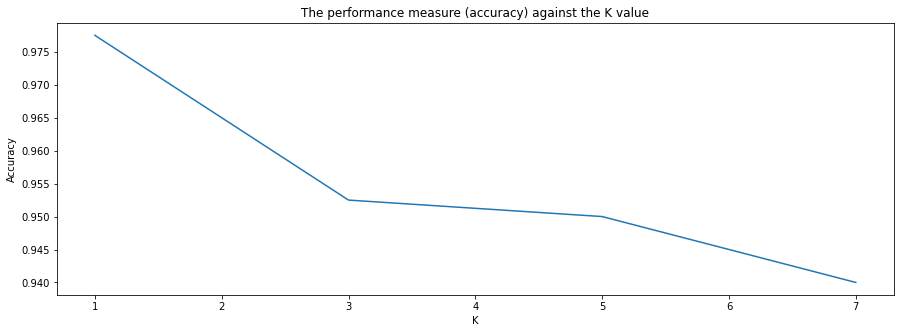

In [ ]:
PCAscoreList = []
for k in range(1,8,2):
    PCAscoreList.append(knn(reducedTrain4,trainLabel,reducedTest4,testLabel,k))
plt.plot([1,3,5,7],PCAscoreList);
plt.title('The performance measure (accuracy) against the K value');
plt.gcf().set_size_inches(15,5);
plt.xlabel('K');
plt.ylabel('Accuracy');

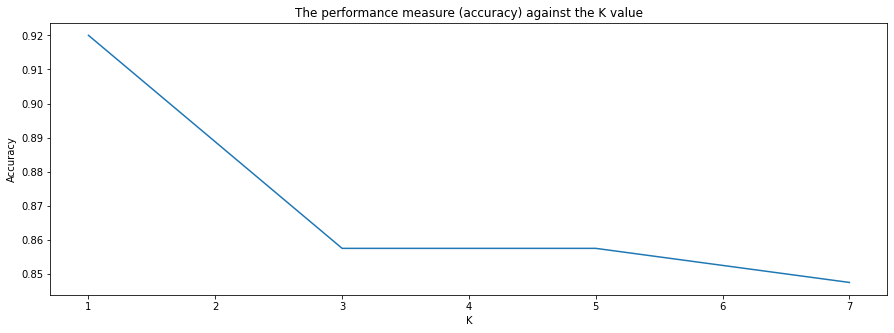

In [ ]:
LDAscoreList = []
for k in range(1,8,2):
    LDAscoreList.append(knn(reducedTrainLDA,trainLabel,reducedTestLDA,testLabel,k))
plt.plot([1,3,5,7],LDAscoreList);
plt.title('The performance measure (accuracy) against the K value');
plt.gcf().set_size_inches(15,5);
plt.xlabel('K');
plt.ylabel('Accuracy');